# 1 statische Optimierung ohne Beschränkung

$
f(x) = (x_{1}+2x_{2}-7)^{2} + (2x_{1}+x_{2}-5)^2   \\
$
$
\dot{f}(x) = 
\begin{bmatrix}
10x_{1}+8x{2}-34  & 8x_{1}+10x{2}-38 
\end{bmatrix}
$   

$
\ddot{f}(x) = 
\begin{bmatrix}
10 & 8 \\ 8 & 10
\end{bmatrix}
$



In [ ]:
import sympy as sym
x1, x2 = sym.symbols('x1 x2')
x = sym.Matrix([x1,x2])
y = (x1 +2*x2 -7)**2 + (2*x1+x2-5)**2
y = sym.Matrix([y])
display(y)
display (x)
yd = y.jacobian(x)
display(yd)
display(yd.jacobian(x.T))

In [32]:
import numpy as np
import scipy.linalg as la


# Definition der zu minimierenden Fuktionen
f = lambda x: (x[0]+2*x[1]-7)**2 + (2*x[0]+x[1]-5)**2
df = lambda x: np.array([10*x[0]+8*x[1]-34,8*x[0]+10*x[1]-38])
ddf = np.array([[10,8],[8,10]])

f_tang = lambda x: 0.5*(x[0]**4-16*x[0]**2+5*x[0]+x[1]**4-16*x[1]**2+5*x[1])

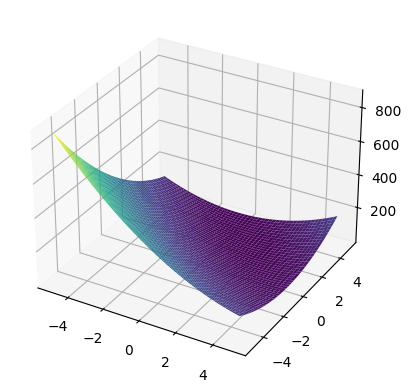

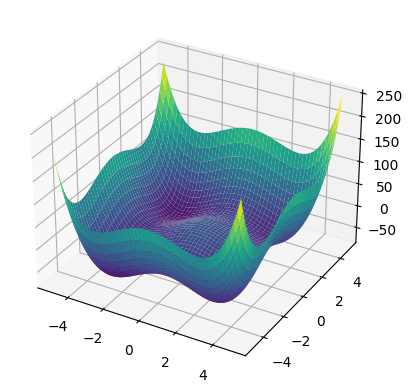

In [33]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
N = 1000
x1 = np.linspace(-5,5,N)
x2 = np.linspace(-5,5,N)
X,Y = np.meshgrid(x1,x2)
Z = f([X,Y])
Z1 = f_tang([X,Y])

ax = plt.figure().add_subplot(projection='3d')
ax2 = plt.figure().add_subplot(projection='3d')
# Plot the 3D surface
ax.plot_surface(X, Y, Z, cmap='viridis')
ax2.plot_surface(X, Y, Z1, cmap='viridis')
plt.show()



## Liniensuchverfahren
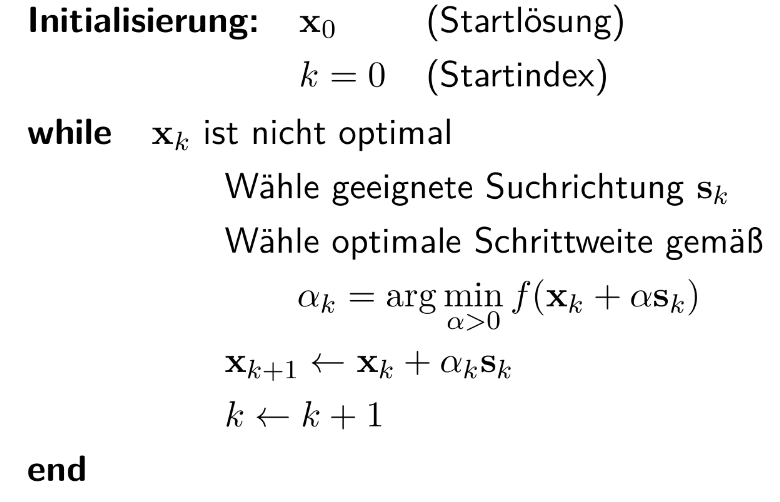

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def NewtonStep(x, df, ddf):   
          
    if np.size(x) > 1:
        return x-np.invert(ddf)@df(x)
    else:   
        beta = 1 
        H = ddf(x) 
        while H <= 0:
            H += beta                   
        return x-H/df(x) 
    

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def bactracking_reg_newton(x,df,ddf):
    b = 0.1
    c = 0.5
    beta = 1 
    H = ddf(x)
    x_delta = x*0

    if np.size(x) > 1:
        if is_pos_def(H):
            H += beta*np.eye(len(x)) 
        x_delta = -np.invert(ddf)@df(x)
    else:          
         
        while H <= 0:
            H += beta                   
        x_delta = -H/df(x) 
    
    alpha = 1
    k = 0
    while f(x +alpha*x_delta) > f(x) + b*alpha*df(x):
        alpha = alpha*c
        k+=1
    #print(x_delta)
    return x + alpha*x_delta

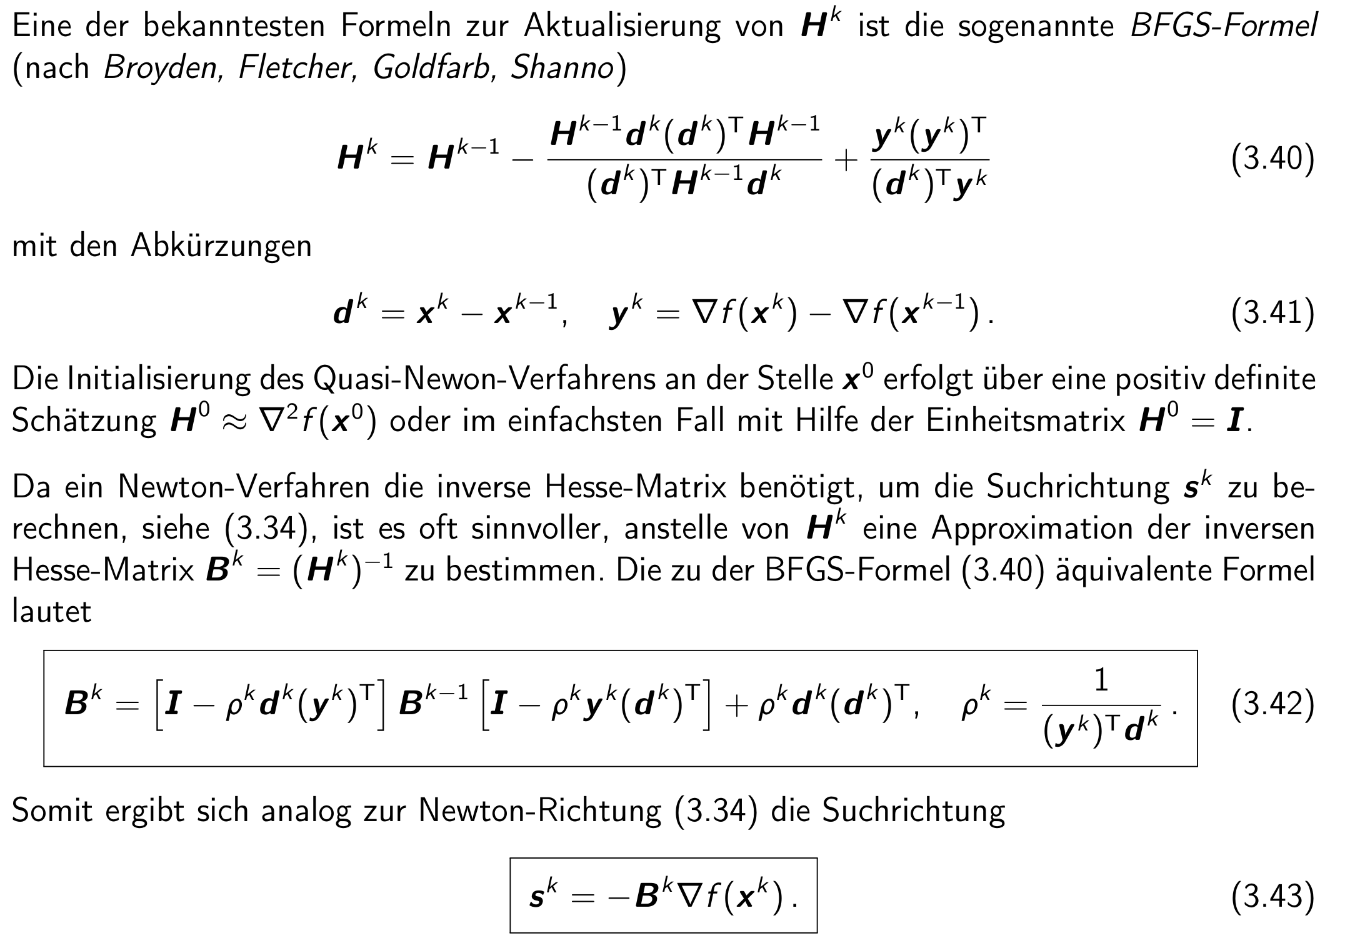   
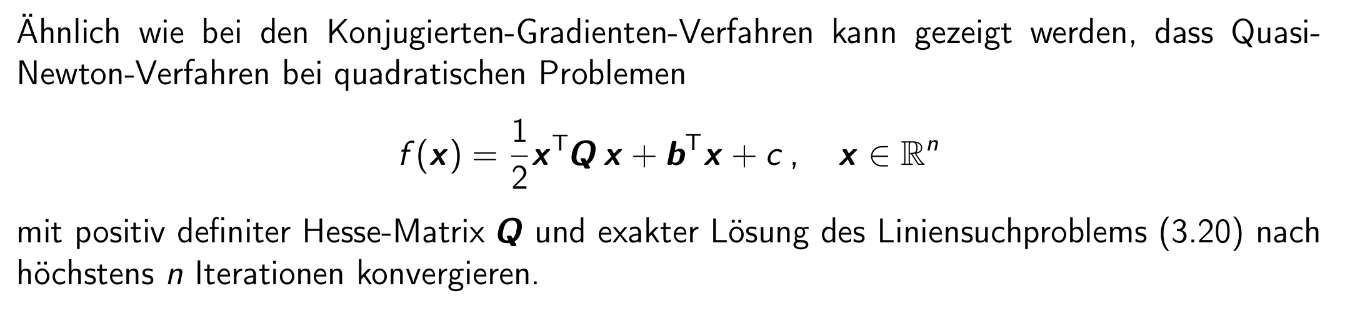

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def quasiNewton(x,x_alt,df, B_alt):
    # Approzimierung der Hesse Matrix
    epsilon = 1e-10
    d = x -x_alt
    y = df(x)-df(x_alt)

    rho = 1/(y*d+epsilon)
    # aktualisieren der Inversen
    B = (1-rho*d*y)*B_alt*(1-rho*y*d) + rho*d**2
            
    # Regularisierung
    beta = 1
    while B <= 0:
            B += beta   
    s = -B*df(x)
                   
        


    # Schrittweite bestimmen mittels Powell-Wolfe Verfahren
    alpha = 1
    c = 0.5
    b = 1
    k = 0
    while f(x +alpha*s) > f(x) + b*alpha*df(x) and k<10:
        alpha = alpha*c
        k+=1
    #print(s*alpha)
    #alpha = 1
    return x + alpha*s , B

def quasiNewton_3D(x,x_alt,df, B_alt):
    # Approzimierung der Hesse Matrix
    epsilon = 1e-30
    d = np.array([x -x_alt])
    y = np.array([df(x)-df(x_alt)])

    rho = 1/(y@d.T +epsilon)
    # aktualisieren der Inversen
    B = (np.eye(len(x))-rho*d.T@y)*B_alt*(np.eye(len(x))-rho*y.T@d) + rho*d.T@d
            
    # Regularisierung
    beta = np.eye(len(x))*0.01
    while not np.all(np.linalg.eigvals(B)):
            B += beta       
    s = -B@df(x)

 
    # Schrittweitenstrategie
    
    # Amerigo
    '''
    b = 1
    alpha = 1
    c= 0.5 
    while f(x +alpha*s) >= f(x) + b*alpha*np.linalg.norm(df(x)):
        alpha = alpha*c        
    '''
    # Wolf Powel, vereinfacht
    
    alpha = 1
   
    b= 0.5
    while f(x+alpha*s)>f(x):
        alpha = alpha*b        

    return x + alpha*s , B


In [35]:
def Forward_diff(f,x):   
    # Vorwärtsdifferenzen 
    h_opt = (np.finfo(float).eps)**(1/2)     
    h = np.zeros(len(x))
    gradient = np.zeros(len(x))
    for i in range(len(x)):
        h   = h*0
        h[i] += h_opt 
        gradient[i] = (f(x+h)-f(x))/h_opt        


    return gradient

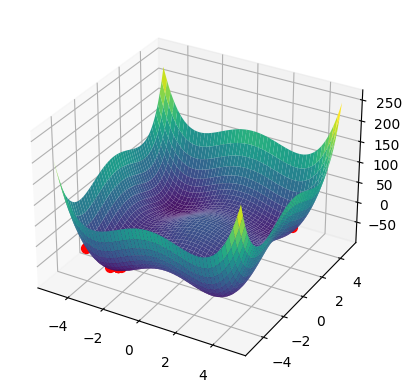

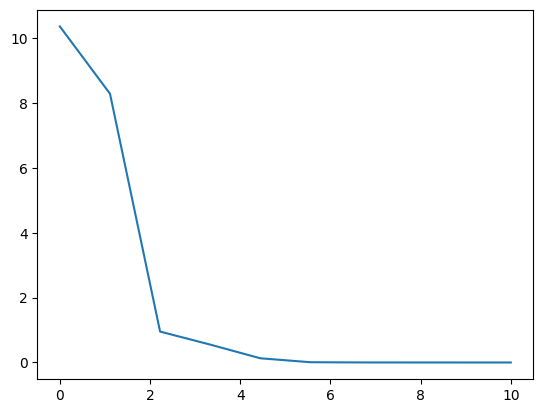


[-2.90353392 -2.90353392]
-78.33233140754247
10
1.2101662163063273e-06


In [38]:
def Linesearch(x0,f,df,ddf,N,e_x = 1e-5, e_f = 1e-15):
    """ Animation
        Params
         --------
        x0:            Startwerte
        e_x:           Abbruchkriterium für die Schrittweite
        e_f:           Abbruchkriterium für den Funktionswert
        f:             Funktion
        df:            Ableitung der Funktion
        Returns
        --------     

        x:              Minimum     
        k:              steps
        X:        Step size                                       
    """

    x = x0  
    x_alt = x0    
    k = 0
    B0 = 1 #np.eye(np.size(x))  
    x = x0 - 1e-3*Forward_diff(f,x0)
    X = np.zeros(N)
    while k < N:       
              
        
        #x = NewtonStep(x_alt,df,ddf)    
        #x = bactracking_reg_newton(x_alt,df,ddf)  
        #x,B0 = quasiNewton(x,x_alt,df,B0)
        x,B0 = quasiNewton_3D(x,x_alt,df,B0)
        

        #plt.plot(x,f(x),'ro')
        ax.scatter(x[0],x[1],f(x), c='r', marker='o', s = 50)        
        #print(f(x))            
        X[k] = np.linalg.norm(x_alt-x)
        k += 1 
        # Abbruchkriterium
        if np.linalg.norm(x_alt-x) < e_x or np.linalg.norm(df(x_alt)-df(x)) < e_f:            
            return x,k,X

        x_alt = x 
        
        
            

    return x,k,np.linalg.norm(x_alt-x),X


#f = lambda x:      x**4 +x**3 -x**2 -x
#df = lambda x:   4*x**3 +3*x**2 -2*x -1
#ddf = lambda x: 12*x**2 +6*x -2

#t = np.linspace(-1.75,1.25,1000)
#plt.plot(t,f(t))

ax = ax2
f = f_tang
ax = plt.figure().add_subplot(projection='3d')
# Plot the 3D surface
ax.plot_surface(X, Y, Z1, cmap='viridis')


x0 = np.array([-4,-4])
#plt.plot(x0,f(x0),'ro')

ax.scatter(x0[0],x0[1],f(x0), c='r', marker='o', s = 50)
df = lambda x: Forward_diff(f,x)


x_opt,k,tol = Linesearch(x0,f,df,ddf,100)


ax.scatter(x_opt[0],x_opt[1],f(x_opt), c='r', marker='o', s = 50)
plt.show()


plt.plot(np.linspace(0,k,k),tol[0:k])
plt.show()

print('')
print(x_opt)
print(f(x_opt))
print(k)
print(tol[-1])

